# *MultipathLocationEstimator* Second tutorial: estimation algorithm

*MultipathLocationEstimator* is an open-source Python class for location in multipath channels, which contains several estimation algorithms for UE **(User Equipment)** positioning. The official documentation can be found [here](https://github.com/gomezcuba/CASTRO-5G/tree/main). This document is a tutorial in Jupyter Notebook that helps users understand the internal logic and intended use of this class, divided in two parts:


1. [First tutorial](./Tutorial_1_MultipathLocationEstimator.ipynb): The first tutorial is focused in understanding the definition of the channel parameters between the BS (Base Station) and the UE. In other words, how it is established the coordinates and geometric system without going into detail in how the user position is computed.
2. [Second tutorial](./Tutorial_2_MultipathLocationEstimator.ipynb): This second tutorial is focused on understanding how UE position is estimated and computed from the channel parameters. For this purpose, <i>MultipathLocationEstimator</i> class includes different estimation algorithms that will be described along the notebook, as well as a comparison of their performance, time execution and precision in the results.

In this first tutorial you will learn how to:

1. Understand the problem of clock error
2. Create an instance of the *MultipathLocationEstimator* class
3. Computing the value of the UE position and clock error assuming $\phi_0$ is known
4. Estimate the value of $\phi_0$ (orientation offset)
5. Test and compare the different algorithms that implement the class <i>MultipathLocationEstimator

# Table of Contents:

1. [Clock offset error model](#1.-Clock-offset-error-model)
2. [MultipathLocationEstimator object](#2.-MultipathEstimationLocation-object)
3. [Solving UE location with clock error](#3.-Solving-UE-location-with-clock-error)
4. Solving UE offset orientation
    - 3.1 Brute force method
    - 3.2 Optimization method
    - 3.3 Group formation strategies
5. Solving UE location from estimated parameters
6. Performance
7. References

# 1. Clock offset error model

In the previous tutorial, we have talked about how $\phi_0$ could affect DAoA measurement. Therefore, receiver’s measured DAoA will be rotated with regard to the absolute AoA in the global coordinate system. 

In the second tutorial we will introduce the full model of the clock offset $\tau_e$. This offset will model the unknown initial time reference for the measurement of DToA at the receiver. In a LOS channel with perfect clock synchronization, the delays between the different multipath channels would be measured as
\begin{equation}
\Delta \tau_i ^{perfectLOS} = \tau_i - \tau_0
\end{equation}
whereas in a LOS with perfect clock, they would be
\begin{equation}
\Delta \tau_i ^{perfectNLOS} = \tau_i - \min\tau_i
\end{equation}
due to the fact that the receiver can only start measuring when the first signal arrives.

If we add, on top of the above, some arbitrary offset of the UE receiver clock with reagard to the BS transmitter clock, we can generally represent that the receiver only knows:
\begin{equation}
\Delta \tau_i  = \tau_i - \tau_e
\end{equation}
Where $\tau_e$ absorbs in it all the mixed effects of $\tau_o$, $\min\tau_i$, the fact that the LOS condition status is unknown, and the potential circuit clock differences. For all of the above effects, regardless, the delay measurement clock offset $\tau_e$ is the same for all paths. At this stage we do not model individual independent noise components representing error in the delay measurement. 

# 2. MultipathEstimationLocation object

The *MultipathLocationEstimator* provides several algorithms recover the UE position trigonometrically, denoted $(d_{ox},d_{oy})$, as well as the value of the clock offset $\tau_e$ and UE orientation offset $\phi_o$. For this, the algorithm receives as inputs the AoDs, AoAs and DToAs as measured by the receiver.

The configuration parameters of the MultipathEstimationLocation object instance are:
    
- *Npoint* (int, optional):  Total point divisions in the minimization range of brute force search
- *RootMethod* (str, optional): Type of solver for $\phi_o$

In [1]:
import sys
sys.path.append('../')

#Import for show the progress bar time execution
import time
from progress.bar import Bar

#Import for the optimization algorithms
import scipy.optimize as opt

#Import to use NumPy arrays
import numpy as np

#Import Pandas
import pandas as pd

#Import for making plots 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

#Plot size
plt.rcParams["figure.figsize"] = (18, 18)

#Plot page style, rerun this cell if it doesnt work
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

#Import MultipathLocationEstimator
from CASTRO5G import MultipathLocationEstimator

# Instance of MultipathLocationEstimator object
loc = MultipathLocationEstimator.MultipathLocationEstimator(Npoint = 100, RootMethod = "lm")

# 3. Solving UE location with clock error

When the UE orientation $\phi_o$ is known, or an estimation of it is provided, it is possible to compute all locations and clock offset using a simle linear LS algorithm. This is implemented by the function

    MultipathLocationEstimator.computeAllPaths(AoD, DAoA, TDoA, phi0_est):

To call this function with a perfectly known *phi0_est*$=\phi_{Ao}$ is quivalent to calling it with the absolute values of AoA in place of DAoA

In [2]:
# Number of total users allocated in the plane
Nuser = 1

# Number of scattering paths (number of scatters)
Npath = 10

# We generate a random location for the Nuser users
d_0x = np.random.rand(Nuser)*100 - 50
d_0y = np.random.rand(Nuser)*100 - 50

# We generate random locations for scatters in a 100m [-50 y 50] square
# We place one scatter in each NLOS path
d_ix = np.random.rand(Npath, Nuser)*100 - 50
d_iy = np.random.rand(Npath, Nuser)*100 - 50

# All angles are in radians units
# With el mod operator, we substract 2pi from the angle if it is higher than 2pi
AoD_0 = np.arctan(d_0y/d_0x)
AoD_0 = np.mod(AoD_0 + np.pi*(d_0x < 0), 2*np.pi)

AoD_i = np.arctan(d_iy/d_ix)
AoD_i = np.mod(AoD_i + np.pi*(d_ix < 0), 2*np.pi)

AoA_i = np.arctan((d_iy - d_0y)/(d_ix - d_0x))
AoA_i = np.mod(AoA_i + np.pi*((d_ix - d_0x) < 0), 2*np.pi)

#We generate a random angle for UE offset
phi_0 = np.random.rand(Nuser)*2*np.pi
DAoA_i = np.mod(AoA_i - phi_0, 2*np.pi)

# LOS path delay
c = 3e8
l_0 = abs(d_0y / np.sin(AoD_0))
tau_0 = l_0 / c

# NLOS path delay
l_i = np.abs(d_iy / np.sin(AoD_i)) + np.abs((d_iy - d_0y) / np.sin(AoA_i))
tau_i = l_i / c

#delay estimation error
clock_error=(40/c)*np.random.rand(1,Nuser)
tauE=tau_0+clock_error
TDoA_i = tau_i - tauE

(x0_est,y0_est,clkoff_est,x_est,y_est)=loc.computeAllPaths(AoD_i[:,0],DAoA_i[:,0],TDoA_i[:,0],phi_0[0])

#perfect location estimation without offset
(x0_perf,y0_perf,_,x_perf,y_perf)=loc.computeAllPaths(AoD_i[:,0],AoA_i[:,0],TDoA_i[:,0],0)

print("""UE location
    true value: (%.2f,%.2f) m
    estimated: (%.2f,%.2f) m
    estimated no offset: (%.2f,%.2f) m
    """%(d_0x,d_0y,x0_est,y0_est,x0_perf,y0_perf))
print("""Clock offset
    true TauE: %.2f ns
    true Tau0: %.2f ns
    true clock offset: %.2f ns
    estimated clock offset: %.2f ns
    """%(tauE*1e9,tau_0*1e9,clock_error*1e9,-clkoff_est*1e9))

print("Scatterer\t|true location\t\t|estimated \t\t|estimated no offset")
for npath in range(Npath):
    print("%d\t\t|(%6.2f,%6.2f) m\t|(%6.2f,%6.2f) m\t|(%6.2f,%6.2f) m"%(npath,d_ix[npath,0],d_iy[npath,0],x_est[npath],y_est[npath],x_perf[npath],y_perf[npath]))

UE location
    true value: (25.15,45.03) m
    estimated: (25.15,45.03) m
    estimated no offset: (25.15,45.03) m
    
Clock offset
    true TauE: 235.16 ns
    true Tau0: 171.93 ns
    true clock offset: 63.24 ns
    estimated clock offset: 63.24 ns
    
Scatterer	|true location		|estimated 		|estimated no offset
0		|(  1.21, -0.79) m	|(  1.21, -0.79) m	|(  1.21, -0.79) m
1		|( 17.67,  4.90) m	|( 17.67,  4.90) m	|( 17.67,  4.90) m
2		|( 46.14,-31.11) m	|( 46.14,-31.11) m	|( 46.14,-31.11) m
3		|(-13.46,-36.62) m	|(-13.46,-36.62) m	|(-13.46,-36.62) m
4		|( 11.45, 39.62) m	|( 11.45, 39.62) m	|( 11.45, 39.62) m
5		|( -1.55, -7.62) m	|( -1.55, -7.62) m	|( -1.55, -7.62) m
6		|( -1.17, -4.49) m	|( -1.17, -4.49) m	|( -1.17, -4.49) m
7		|( 22.45, 48.90) m	|( 22.45, 48.90) m	|( 22.45, 48.90) m
8		|(  0.42, 29.74) m	|(  0.42, 29.74) m	|(  0.42, 29.74) m
9		|( 43.25,-28.34) m	|( 43.25,-28.34) m	|( 43.25,-28.34) m


# 4. Solving UE offset orientation

In this section, we will introduce the methods for estimation of the orientation offset $\phi_0$. An unknown rotation can severely limit the performance of our positioning estimation algorithm due to its randomness and non-linear impact on the method. Therefore, to deal with this constraint, we have designed some different methods that can compute its value. 
- A brute forcing algorithm looks over all possible points for the range of $\phi_0 \in [0, 2\pi]$
- A more sophisticated algorithm that finds the solution of a non-linear equation using the standard method *root()* from the *scipy.optimize* package.

Both methods are based on dividing the set of paths $\{1\dots N_p\}$ into $N_G$ groups denoted $\mathcal{G}_1,\mathcal{G}_2\dots\mathcal{G}_{N_G}$. We assume that for each group the location and clock error are estimated as a function of $\phi_o$ denoted
\begin{equation}
F_m(\phi_o)=\left(\begin{array}{c}
        \hat{d}_{oy}^{(m)}\\
        \hat{d}_{ox}^{(m)}\\
        cf\hat{\tau}_E^{(m)} 
     \end{array}\right)
\end{equation}
Implemented by the function

    MultipathLocationEstimator.feval_wrapper_AllPathsByGroupsFun(phi0, AoD, DAoA, TDoA, group_method)
    
Which receives the sets of AoD, DAoA and TDoA as inputs, as well as a *group_method* optional parameter, and returns the estimated position vectors $(\hat{d}_ox, \hat{d}_oy)$ and initial delays $\hat{\tau}_e$ of the UE. These position vectors are obtained from the linear system equation describe din the previous section. In the later sections we explain more about the different grouping strategies.

Finally, we note that for a correct value of $\phi_o$, all groups should calculate the same estimation of the location.

. 


</span>

/usr/lib/python3/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/lib/python3/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/lib/python3/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' w

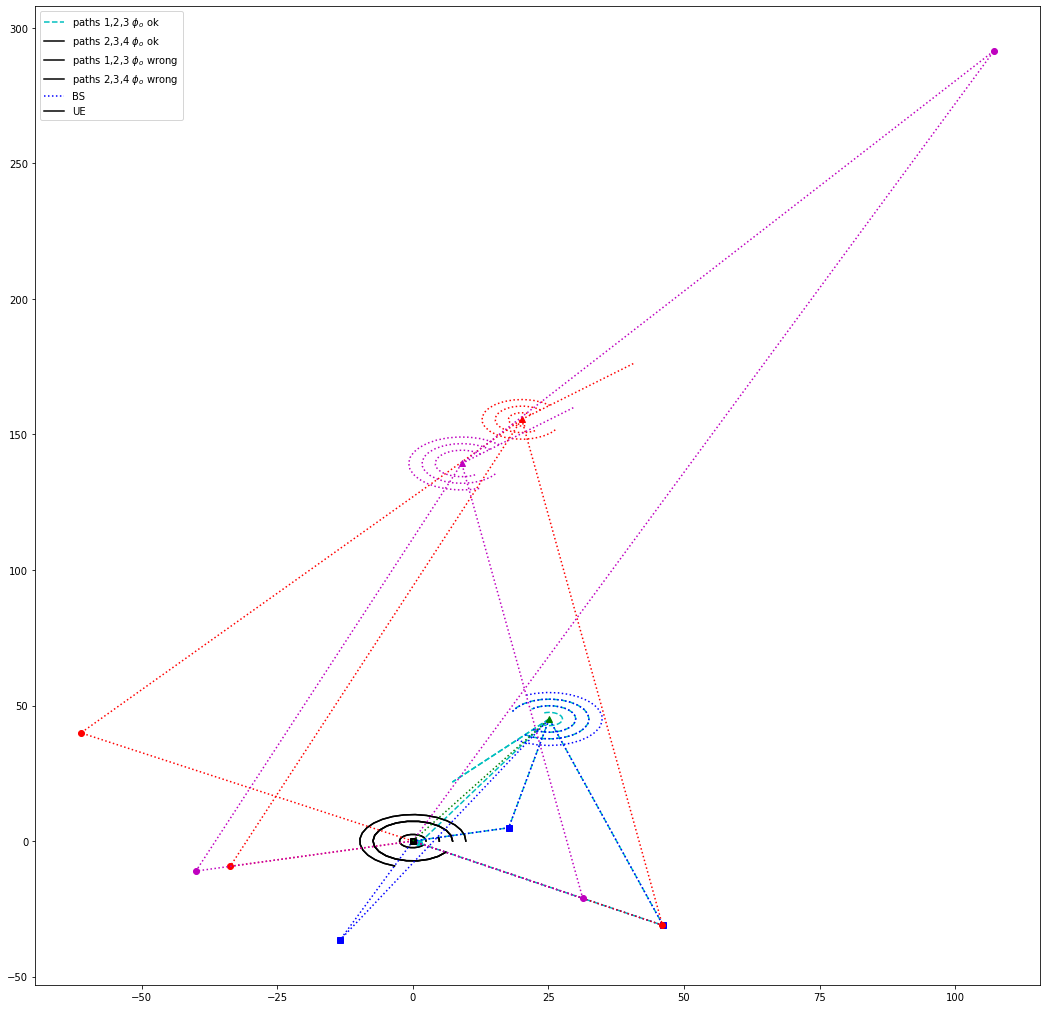

In [3]:
plt.figure(1)
scaleguide=np.max(np.abs(np.concatenate([d_0x,d_0y,d_ix[:,0],d_iy[:,0]],0)))
t=np.linspace(0,1,21)
#show 4 path AODs
for p in range(4):
    plt.plot(0+scaleguide*.05*(p+1)*np.cos(AoD_i[p]*t),0+scaleguide*.05*(p+1)*np.sin(AoD_i[p]*t),'k', label='_nolegend_')

#paths in G1 = {1...3}, with AoAs and correct phi_0 leading to correct location
plt.plot([d_0x[0],d_0x[0]+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.cos(phi_0)],[d_0y[0],d_0y[0]+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.sin(phi_0)],'c--', label='_nolegend_')
for of in range(3):
    p=0+of
    plt.plot([0,d_ix[p,0],d_0x[0]],[0,d_iy[p,0],d_0y[0]],'c--', label='_nolegend_' if of > 0 else '')
    plt.plot(d_ix[p,0],d_iy[p,0],'oc', label='_nolegend_')    
    plt.plot(0+scaleguide*.05*(p+1)*np.cos(AoD_i[p]*t),0+scaleguide*.05*(p+1)*np.sin(AoD_i[p]*t),'k')
    plt.plot(d_0x[0]+scaleguide*.05*(p+1)*np.cos(AoA_i[p]*t+phi_0),d_0y[0]+scaleguide*.05*(p+1)*np.sin(AoA_i[p]*t+phi_0),'c--', label='_nolegend_')

#paths in G2 = {2...4}, with AoAs and correct phi_0 leading to correct location
plt.plot([d_0x[0],d_0x[0]+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.cos(phi_0)],[d_0y[0],d_0y[0]+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.sin(phi_0)],'c--', label='_nolegend_')
for of in range(3):
    p=1+of
    plt.plot([0,d_ix[p,0],d_0x[0]],[0,d_iy[p,0],d_0y[0]],'b:', label='_nolegend_' if of > 0 else '')
    plt.plot(d_ix[p,0],d_iy[p,0],'sb', label='_nolegend_')    
    plt.plot(0+scaleguide*.05*(p+1)*np.cos(AoD_i[p]*t),0+scaleguide*.05*(p+1)*np.sin(AoD_i[p]*t),'k')
    plt.plot(d_0x[0]+scaleguide*.05*(p+1)*np.cos(AoA_i[p]*t+phi_0),d_0y[0]+scaleguide*.05*(p+1)*np.sin(AoA_i[p]*t+phi_0),'b:', label='_nolegend_')

(x0_bad,y0_bad,tauEall_bad,x_bad,y_bad)= loc.computeAllPaths(AoD_i[0:3],DAoA_i[0:3],TDoA_i[0:3],np.pi/4)
plt.plot(x0_bad,y0_bad,'^r', label='_nolegend_')
plt.plot([x0_bad,x0_bad+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.cos(np.pi/4)],[y0_bad,y0_bad+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.sin(np.pi/4)],'r:', label='_nolegend_')
#paths in G1 = {1...3}, with AoAs and incorrect phi_0 leading to wrong location
for of in range(3):
    p=0+of
    plt.plot([0,x_bad[of],x0_bad],[0,y_bad[of],y0_bad],'r:', label='_nolegend_' if of > 0 else '')
    plt.plot(x_bad[of],y_bad[of],'or', label='_nolegend_')
    plt.plot(x0_bad+scaleguide*.05*(p+1)*np.cos(AoA_i[p]*t+np.pi/4),y0_bad+scaleguide*.05*(p+1)*np.sin(AoA_i[p]*t+np.pi/4),'r:', label='_nolegend_')

(x0_bad,y0_bad,tauEall_bad,x_bad,y_bad)= loc.computeAllPaths(AoD_i[1:4],DAoA_i[1:4],TDoA_i[1:4],np.pi/4)
plt.plot(x0_bad,y0_bad,'^m', label='_nolegend_')
plt.plot([x0_bad,x0_bad+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.cos(np.pi/4)],[y0_bad,y0_bad+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.sin(np.pi/4)],'m:', label='_nolegend_')
for of in range(3):
    p=1+of
    plt.plot([0,x_bad[of],x0_bad],[0,y_bad[of],y0_bad],'m:', label='_nolegend_' if of > 0 else '')
    plt.plot(x_bad[of],y_bad[of],'om', label='_nolegend_')
    t=np.linspace(0,1,21)
    plt.plot(x0_bad+scaleguide*.05*(p+1)*np.cos(AoA_i[p]*t+np.pi/4),y0_bad+scaleguide*.05*(p+1)*np.sin(AoA_i[p]*t+np.pi/4),'m:', label='_nolegend_')

plt.plot(0,0,'sk')
plt.plot(d_0x[0],d_0y[0],'^g')
plt.plot([0,d_0x[0]],[0,d_0y[0]],':g')
plt.legend(['paths 1,2,3 $\\phi_o$ ok','paths 2,3,4 $\\phi_o$ ok','paths 1,2,3 $\\phi_o$ wrong','paths 2,3,4 $\\phi_o$ wrong','BS','UE'])

 Therefore, we can simply solve the system of non-linear equations of $\phi_o$ given by $F_{1}(\phi_o)=F_{2}(\phi_o)=\dots=F_{N_G}(\phi_o)$. To accomodate the use case where multipath data is not known perfectly and location commits errors, we solve this system of equations in the *Minimum Mean Squared Error* (MMSE) sense, that is we minimize
\begin{equation}
\label{eq:minmselin}
 \min_{\phi_o'}\sum_{m=1}^{N_G} \left\|F_{m}(\phi_o')-\overline{F}(\phi_o')\right\|^2\textnormal{ s.t. }\overline{F}(\phi_o')=\frac{\sum_{m=1}^{N_G} F_{m}(\phi_o')}{N_G}
\end{equation}

<span style=" font-size:19px; font-family: Calibri">
The parameters of the methods to estimate $\phi_0$ are:
    
<div style = "background-color:#D0ECE7 ">   
<span style=" font-size:19px; font-family: Calibri">-> <i><b> AoD </b></i>: ndarray <br> Angles of Departure of the NLOS ray propagation, measured in the BS from de positive x-axis in the non-clockwise.
</span><br>

<br> 
<span style=" font-size:19px; font-family: Calibri">-> <i><b> AoA </b></i>: ndarray <br>Angles of Arrival of the NLOS ray propagation, measured in the UE from de positive x-axis in the non-clockwise sense. The value of phi_0 can modify the orientation of the x-axis.
</span><br>

<br> 
<span style=" font-size:19px; font-family: Calibri">-> <i><b> dels </b></i>: ndarray <br> Delays introduced by the NLOS ray propagations.
</span><br>

<br> 
<span style=" font-size:19px; font-family: Calibri">-> <i><b> Npoint </b></i>: ndarray <br> Total point divisions in the minimization range of search.
</span><br>

<br> 
<span style=" font-size:19px; font-family: Calibri">-> <i><b> init_phi0 </b></i>: ndarray <br> Hint about the value of phi0.
</span><br>
    
<br> 
<span style=" font-size:19px; font-family: Calibri">-> <i><b> group_method </b></i>: ndarray, optional <br> Path grouping strategy.
</span>
<br><br>

<a class="anchor" id="4.1"></a>

<br><br>
<span style="color:black; font-size:28px; font-family: Cambria" name ="A"><b> 4.1 Brute force method
</b></span><br>

<span style=" font-size:19px; font-family: Calibri">
The brute force method generates thousands of points in the interval of $[0, 2\pi]$ and picks the one with the
lowest MSE. With this aim, the algorithm obtained the zeros of the given vector function defined by <i>feval_wrapper_AllPathsByGroupsFun</i> and reduces recurrently the solution range till minimize the error in the estimation.
<br><br>
The performance of this estimator will be determined by the grouping methodology, group_method, the number of divisions, Npoint, and the number of total paths, Npath. Hence, increasing these two last variables will increase the accuracy of the method, but with the disadvantage of a higher time in computation. Therefore, it is important to look for an agreement between these parameters and try to search the best for each scenario.
</span>
<br><br>

In [4]:
brute_phi0 = loc.brutePhi0ForAllPaths(AoD_i[:,0], DAoA_i[:,0], TDoA_i[:,0], Npoint = 1000, group_method="drop1")

print("brute_phi0 = ", brute_phi0[0], "rad")

brute_phi0 =  4.056711234365198 rad


<a class="anchor" id="4.2"></a>

<br><br>
<span style="color:black; font-size:28px; font-family: Cambria" name ="A"><b> 4.2 Linear method
</b></span><br>

<span style=" font-size:19px; font-family: Calibri">
On the other hand, the root method obtained the value of offset orientation by finding the zeros of the MSE function, but using the method <i>root()</i> to compute the solution.
<br><br>
This algorithm also can receive an initial guess or hint about what is the value of $\phi_0$, so we can make a large aproximation with the brute force algorithm to make a more acurate estimation. Nowadays, in real UE frameworks there are available some sensors as acelerometers, giroscopes and magnetometers that are capable of measuring orientation angles in the different axis $(x, y, z)$, which could provide the hint value for algorithm initialization.
<br><br>
In this case, the performance of the estimator will be directly determinated by the accuracy of the hint value provided by the brute force algorithm and the RootMethod for computing the roots of the non-linear ecuation sistem.
</span>
<br><br>

In [5]:
phi0_fsolve, _ = loc.solvePhi0ForAllPaths(AoD[:,0], AoA[:,0], dels[:,0], brute_phi0, group_method="drop1", RootMethod = "lm")

print("phi0_fsolve = ", phi0_fsolve[0], "rad")

NameError: name 'AoD' is not defined

<a class="anchor" id="4.3"></a>

<br><br>
<span style="color:black; font-size:28px; font-family: Cambria" name ="A"><b>4.3 Group strategies for $\phi_0$ computation
</b></span><br>

<span style=" font-size:19px; font-family: Calibri">
In this subsection, we are going to introduce what are group strategies and how they can affect in the estimation performance. These, allows us to group NLOS path parameters ${AoA, AoD, dels}$ for the algorithms iterations, what means how we are going to create our linear system matrix to compute $\phi_0$ value. For this purpose, it's important to follow the constraint that minimal path groups must contain at least 3 different paths.
<br><br>
Group strategies are created by boolean arrays where True values specified the paths that are taken for groups.
</span>

<span style=" font-size:19px; font-family: Calibri">
In <i>MultipathLocationEstimator</i> have been created 3 predefined group strategies:
    
<div style = "background-color:#D0ECE7 "><br>
<span style=" font-size:19px; font-family: Calibri">-> <i><b> gen3PathGroup (group_method = '3path'): </b></i><br>  This function divides the set $\{1, 2, 3, . . ., Npath\}$, where Npath is the total number of NLOS paths into several groups of paths $G1(1, 2, 3), G2(2, 3, 4), G3(3, 4, 5), . . ., Gm(Npath-2, Npath-1, Npath)$. Each group is defined as the result of the combination of 3 paths in a total of $(Npath-2)$ groups.
</span><br>


<br> 
<span style=" font-size:19px; font-family: Calibri">-> <i><b> genDrop1Group (group_method = 'drop1'): </b></i><br> This function divides the set $\{1, 2, 3, . . ., Npath\}$, where Npath is the total number of NLOS paths into many groups of paths $G1, G2 , G3, . . ., Gm$. Each group is defined as the group of all paths except de $m-th$ one. So the $Gm$ group will inclue: $Gm = \{1, . . . ,m-1 , m+1, . . . , Npath\}$.
</span><br> 


<br> 
<span style=" font-size:19px; font-family: Calibri">-> <i><b> genRandomGroup (group_method = 'random'): </b></i><br>This function divides the set $\{1, 2, 3, . . ., Npath\}$, where Npath is the total number of NLOS paths into several groups of paths $G1, G2 , G3, . . ., Gm$$m-th$ one. So the $Gm$ group will include: $Gm = \{1, . . . ,m-1 , m+1, . . . , Npath\}$.
</span><br> 


<br> 
<span style=" font-size:19px; font-family: Calibri">-> <i><b> genRandomGroup (group_method = 'random'): </b></i><br>This function divides the set $\{1, 2, 3, . . ., Npath\}$, where Npath is the total number of NLOS paths into many groups of paths $G1, G2 , G3, . . ., Gm$. So the table will include Nlines groups with random $Npath$ values.
</span>
<br><br> 

<span style=" font-size:19px; font-family: Calibri">
Nevertheless, we can also create our customize path group and pass it to the function in array type as the group_method parameter.
</span>
<br><br>

In [ ]:
table_group_3path = loc.gen3PathGroup(Npath)

print(table_group_3path)

In [ ]:
table_group_drop1 = loc.genDrop1Group(Npath)

print(table_group_drop1)

In [ ]:
Nlines = 5
table_group_random = loc.genRandomGroup(Npath, Nlines)

print(table_group_random)

In [ ]:
# Number of points to search the phi_0 angle
Npoint = 1000
phi_0_search = np.linspace(0, 2*np.pi, Npoint).reshape(-1, 1)

In [ ]:
# Compute all posible UE positions for phi_0_search range
x0_3path = np.zeros((Npoint,Npath))
y0_3path = np.zeros((Npoint,Npath))

for ct in range(phi_0_search.size):
    for gr in range(table_group_3path.shape[0]):
        (x0_3path[ct,gr], y0_3path[ct,gr],  _, _, _) = loc.computeAllPaths(AoD[table_group_3path[gr, :]], AoA[table_group_3path[gr, :]], dels[table_group_3path[gr, :]], phi0_est=phi_0_search[ct])

In [ ]:
plt.figure(2)

# Plot the Base Station
plt.plot(0, 0, "sb", label="Base Station")

# Plot the user
plt.plot(d_0x, d_0y, "^g", label="UE")

# Plot LOS path
plt.plot([0, d_0x[0]], [0, d_0y[0]], "--k", label="LOS Path")

# Plot all vectors [x0, y0] solutions
plt.plot(x0_3path, y0_3path, ":+", label="UE posible position vector")

# Limits because curves diverge sharply
plt.axis([-75,75,-75,75])

plt.title("All possible estimations of position for each set of 3 paths, for $\phi_0$ from 0 to 2$\pi$", fontsize=20)
plt.xlabel("Coordinate x", fontsize=18)
plt.ylabel("Coordinate y", fontsize=18)

# Create and avoid label repetitions in the legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={"size": 14})

# Save Figure_4_1 image
plt.savefig(Folder_tutorial_2_dir_path + "/Figure_4_3_1.png")

<span style=" font-size:19px; font-family: Calibri">The figure above, shows all the solutions described by the different possible positions of the UE, function of the range of values of $\phi_0$. Each curve describes one system of linear equations obtained from the parameters values of 3 different multipath channels. As we can see in the plot, all curves cross at the same point, where the UE is located. Hence, at that point the value of the offset orientation is obtained.
<br><br>
Nevertheless, this grouping methodology presents several disadvantages. For some cases it's not accurate enough and diverges sharply when is far from the solution. 
</span>
<br><br>

In [ ]:
# Compute all posible UE positions for phi_0_search range
x0_drop1 = np.zeros((Npoint,Npath))
y0_drop1 = np.zeros((Npoint,Npath))
tauE_drop1 = np.zeros((Npoint,Npath))

for ct in range(phi_0_search.size):
    for gr in range(table_group_drop1.shape[0]):
        (x0_drop1[ct,gr], y0_drop1[ct,gr], tauE_drop1[ct,gr], _, _) = loc.computeAllPaths(AoD[table_group_drop1[gr, :]], AoA[table_group_drop1[gr, :]], dels[table_group_drop1[gr, :]], phi0_est=phi_0_search[ct])

In [ ]:
plt.figure(3)

# Plot the Base Station
plt.plot(0, 0, "sb", label="Base Station")

# Plot the user
plt.plot(d_0x, d_0y, "^g", label="UE")

# Plot LOS path
plt.plot([0, d_0x[0]], [0, d_0y[0]], "--k", label="LOS Path")

# Plot all vectors [x0, y0] solutions
plt.plot(x0_drop1, y0_drop1, ":", label="UE posible position vector")

plt.title("All possible estimations of position for each set of N-1 paths (used in root linear), for $\phi0$ from 0 to 2$\pi$", fontsize=20)
plt.xlabel("Coordinate x", fontsize=18)
plt.ylabel("Coordinate y", fontsize=18)

# Create and avoid label repetitions in the legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={"size": 14})

# Save Figure_4_3_1 image
plt.savefig(Folder_tutorial_2_dir_path + "/Figure_4_3_2.png")

<span style=" font-size:19px; font-family: Calibri">As we have seen before, for the 3-paths method functions, here the curves obtained shows a more elegant solution to compute UE position. Furthermore, this method presents several advantages. It's more accurate and curves diverges less sharply.
</span>
<br><br>

In [ ]:
plt.figure(4)
ax = plt.axes(projection = "3d")

# Plot the Base Station
ax.plot3D([0], [0], [0], "sb", label="Base Station")

# Plot the UE
ax.plot3D(d_0x, d_0y, [0], "^g", label="UE")

# Plot LOS path
ax.plot3D([0, d_0x[0]], [0, d_0y[0]], "--k", label="LOS Path")

# Plot all vectors [x0, y0] solutions
for gr in range(Npath):
    ax.plot3D(x0_drop1[:,gr], y0_drop1[:,gr], tauE_drop1[:,gr], ':', label="UE posible position vector")
    
plt.title("All possible estimations of position and delay, for each set of N-1 paths (used in root linear), for $\phi_0$ from 0 to 2$\pi$", fontsize=20)
ax.set_xlabel("Coordinate x", fontsize=18)
ax.set_ylabel("Coordinate y", fontsize=18)
ax.set_zlabel("Delay", fontsize=18)

# Create and avoid label repetitions in the legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={"size": 14})

# Save Figure_4_3_2 image
plt.savefig(Folder_tutorial_2_dir_path + "/Figure_4_3_3.png")

<span style=" font-size:19px; font-family: Calibri">Here, we present a more clear figure of how UE possibles positions are obtained in function of the value of $\phi_0$. We have added one more dimension, related with delays between multipath channel paths. We can see again that all curves converge to the same point, where the UE is located. 
</span>
<br><br>

<a class="anchor" id="5"></a>

<br><br>
<span style="color:black; font-size:33px; font-family: Cambria" name ="A"><b> 5. Solving UE location
</b></span><br>

<span style=" font-size:19px; font-family: Calibri">
Once we have understood all parameters and constraints of our system model, it's time to perform UE location.
For this purpose, <i>MultipathLocationEstimator</i> includes several methods that help to achieve this task. All of them are wrapped in one parametric function that helps the user to make use of the algorithms, <i>computeAllLocationsFromPaths</i>. This, returns the estimated position of the UE and scatters along the multipath channels and computes the estimation for the orientation offset $\phi_0$.
<br><br>
This first part, will be focused in how to use the different method options and how it performs the UE position for a non-real channel measurements. Afterwards, we are going to introduce some delay error in the $dels$ estimation and some noise in the $AoA$ and $AoD$ measurements to test how accuracy and robust is the algorithm.
<br><br>
With this aim, we generate $Nuser = 50$ UE positions $(d_0x, d_0y)$ and $Npath × Nuser = 7×50$ reflector locations $(d_{ix}, d_{iy})$, both randomly uniformly distributed in a square of size of $(100 * 100) m$, that simulates the plane where UE, BS and scatter are placed. The terminal orientation is also random $\phi_0\sim U(0, 2\pi)$.
</span>

<span style=" font-size:19px; font-family: Calibri">The call to the UE position algorithm is: <br></span>
<span style=" font-size:20px; font-family: Calibri"><i>'computeAllLocationsFromPaths(AoD=AoD, AoA=AoA, dels=dels, method='fsolve', hint_phi0=None)'</i>
</span>
<br>

<span style=" font-size:19px; font-family: Calibri">
The parameter '<b>method</b>' options:

<div style = "background-color:#D0ECE7 ">   
<span style=" font-size:19px; font-family: Calibri">-> <i><b> 'brute' </b></i><br><i>brutephi0ForAllPaths()</i> to estimate $\phi_0$.
</span><br>

<br> 
<span style=" font-size:19px; font-family: Calibri">-> <i><b> 'fsolve' </b></i><br><i>solvephi0ForAllPaths()</i> to estimate $\phi_0$.
</span>
<br><br>

In [ ]:
# Number of scattering paths (number of scatters)
Npath = 20

# Number of total users allocated in the plane
Nuser = 100

In [ ]:
# We generate random locations for scatters in a 100m [-50 y 50] square
# We place one scatter in each NLOS path
d_ix = np.random.rand(Npath, Nuser)*100 - 50
d_iy = np.random.rand(Npath, Nuser)*100 - 50

# We generate a random location for Nuser users
d_0x = np.random.rand(1, Nuser)*100 - 50
d_0y = np.random.rand(1, Nuser)*100 - 50

In [ ]:
# All angles are in radians units
# With el mod operator, we substract 2pi from the angle if it is higher than 2pi
theta_0 = np.arctan(d_0y/d_0x)
theta_0 = np.mod(theta_0 + np.pi*(d_0x < 0), 2*np.pi)

theta_i = np.arctan(d_iy/d_ix)
theta_i = np.mod(theta_i + np.pi*(d_ix < 0), 2*np.pi)

phi_i = np.arctan((d_iy - d_0y)/(d_0x - d_ix))
phi_i = np.mod(np.pi - phi_i + np.pi*((d_0x - d_ix) < 0), 2*np.pi)

In [ ]:
# Ligth speed
c = 3e8

# LOS path length
l_0 = abs(d_0y / np.sin(theta_0))

# LOS path time delay
tau_0 = l_0 / c

# NLOS path length
l_i = np.abs(d_iy / np.sin(theta_i)) + np.abs((d_iy - d_0y) / np.sin(phi_i))

# NLOS path time delay
tau_i = l_i / c

In [ ]:
# We generate a random angle for the offset
phi_0 = np.random.rand(1,Nuser)*2*np.pi

In [ ]:
AoD = np.mod(theta_i, 2*np.pi)

AoA = np.mod(phi_i - phi_0, 2*np.pi)

In [ ]:
dels = tau_i - tau_0 

In [ ]:
plt.figure(5)

# Plot the Base Station
plt.plot(0, 0, "sb", label="Base Station")

# Plot the User
plt.plot(d_0x, d_0y,"ob",label="UE")

for ue in range(Nuser):
    (phi0_brute, d_0x_brute, d_0y_brute,_,_,_,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], Npoint=100, phi0_method="brute", group_method='drop1')   
    plt.plot(d_0x_brute, d_0y_brute,"+g",label="fzero $\phi_o$ brute")
    plt.plot([d_0x[0,ue], d_0x_brute], [d_0y[0,ue], d_0y_brute], ":g")

    (phi0_fsolve, d_0x_fsolve, d_0y_fsolve,_,_,_,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=phi0_brute, phi0_method="fsolve", group_method='drop1', RootMethod = "lm")    
    plt.plot(d_0x_fsolve, d_0y_fsolve,"+r",label="fzero $\phi_o$ fsolve hint")
    plt.plot([d_0x[0,ue],d_0x_fsolve], [d_0y[0,ue],d_0y_fsolve], ":r")

plt.title("Location error between estimators vs real UE positions",  fontsize=20)
plt.xlabel("Coordinate x",  fontsize=18)
plt.ylabel("Coordinate y",  fontsize=18)

# Create and avoid label repetitions in the legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={"size": 14})

# Save Figure_5_1_B image
plt.savefig(Folder_tutorial_2_dir_path + "/Figure_5.png")

<a class="anchor" id="5.1"></a>

<br><br>
<span style="color:black; font-size:28px; font-family: Cambria" name ="A"><b> 5.1 Solving UE location with clock error
</b></span><br>

<span style=" font-size:19px; font-family: Calibri">
Next, we use the methods explained in previous sections but introducing now some errors in channel parameters measurements to simulate possibles errors introduced in the position estimation. For this, you can go back to <a href="#1.1">section 1.1</a> to refresh clock offset error basics.
<br><br>
For this part, we use the same UE, BS and scatter map. Additionally, clock error is randomly distributed as $\tau_e\sim U(0, 40ns)$.
</span>

In [ ]:
#delay estimation error
clock_error=(40/c)*np.random.rand(1,Nuser)

dels = tau_i - tau_0 + clock_error

In [ ]:
plt.figure(5)

# Plot the Base Station
plt.plot(0, 0, "sb", label="Base Station")

# Plot the User
plt.plot(d_0x, d_0y,"ob",label="UE")

for ue in range(Nuser):
    
    (phi0_brute, d_0x_brute, d_0y_brute,_,_,_,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], Npoint=100, phi0_method="brute", group_method='drop1')    
    plt.plot(d_0x_brute, d_0y_brute,"+g",label="fzero $\phi_o$ brute")
    plt.plot([d_0x[0,ue], d_0x_brute], [d_0y[0,ue], d_0y_brute], ":g")

    (phi0_fsolve, d_0x_fsolve, d_0y_fsolve,_,_,_,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=phi0_brute, phi0_method="fsolve", group_method='drop1', RootMethod = "lm")    
    plt.plot(d_0x_fsolve, d_0y_fsolve,"+r",label="fzero $\phi_o$ fsolve hint")
    plt.plot([d_0x[0,ue],d_0x_fsolve], [d_0y[0,ue],d_0y_fsolve], ":r")

plt.title("Location error between estimators vs real UE positions",  fontsize=20)
plt.xlabel("Coordinate x",  fontsize=18)
plt.ylabel("Coordinate y",  fontsize=18)

# Create and avoid label repetitions in the legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={"size": 14})

# Save Figure_5_1_B image
plt.savefig(Folder_tutorial_2_dir_path + "/Figure_5_1.png")

<span style=" font-size:19px; font-family: Calibri">With this, we can prove that our solution is implicitly robust to constant clock offset errors.
</span>
<br><br>

<a class="anchor" id="5.2"></a>

<br><br>
<span style="color:black; font-size:28px; font-family: Cambria" name ="A"><b> 5.2 Solving UE location from estimated parameters
</b></span><br>

<span style=" font-size:19px; font-family: Calibri">
At this point, all seems to work perfectly, and the algorithms looks to perform very well the UE position, but we have not taken in account possibles errors that can be taken from the measured of $AoA$, $AoD$ and $dels$ channel parameters.
<br><br>
    For this last section part, we introduce an additive noise term to the multipath components. So, instead of known $\{\theta_i, \phi_i, \tau_i\}$ we used the set of values $\{\theta_i + E\theta_i, \phi_i + E\phi_i, \tau_i + E\tau_i\}$, where the errors are modelled as:
\begin{equation}
E\theta_i, E\phi_i \sim N\left(0, \left(\frac{2\pi}{2N_a}\right)^2\right)
\end{equation}
with Na = 256, a tuning parameter intended to represent the number of antennas of a linear array. <br><br>Moreover, the delay estimation error is modeled as:
\begin{equation}
E\tau_i \sim N(0, T_s^2) 
\end{equation}
where 
\begin{equation}
T_s = \left(\frac{1}{B}\right) = 2.5 ns = \left(\frac{1}{400 MHz}\right) 
\end{equation} 
intended to represent the discrete equivalent channel sample period.
</span>


In [ ]:
Nanterr = 256

AoD = np.mod(theta_i+np.random.rand(Npath,Nuser)*2*np.pi/Nanterr,2*np.pi)
AoA = np.mod(phi_i - phi_0+np.random.rand(Npath,Nuser)*2*np.pi/Nanterr,2*np.pi)

In [ ]:
Tserr = 2.5e-9

#delay estimation error
clock_error = (40/c)*np.random.rand(1,Nuser)

#delay estimation error
del_error = (Tserr)*np.random.randn(Npath,Nuser)

dels = tau_i - tau_0 + clock_error + del_error

In [ ]:
plt.figure(5)

# Plot the Base Station
plt.plot(0, 0, "sb", label="Base Station")

# Plot the User
plt.plot(d_0x, d_0y,"ob",label="UE")

for ue in range(Nuser):
    
    (phi0_brute, d_0x_brute, d_0y_brute,_,_,_,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], Npoint=100, phi0_method="brute", group_method='drop1')    
    plt.plot(d_0x_brute, d_0y_brute,"+g",label="fzero $\phi_o$ brute")
    plt.plot([d_0x[0,ue], d_0x_brute], [d_0y[0,ue], d_0y_brute], ":g")

    (phi0_fsolve, d_0x_fsolve, d_0y_fsolve,_,_,_,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=phi0_brute, phi0_method="fsolve", group_method='drop1', RootMethod = "lm")    
    plt.plot(d_0x_fsolve, d_0y_fsolve,"+r",label="fzero $\phi_o$ fsolve hint")
    plt.plot([d_0x[0,ue],d_0x_fsolve], [d_0y[0,ue],d_0y_fsolve], ":r")

plt.title("Location error between estimators vs real UE positions",  fontsize=20)
plt.xlabel("Coordinate x",  fontsize=18)
plt.ylabel("Coordinate y",  fontsize=18)

# Create and avoid label repetitions in the legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={"size": 14})

# Save Figure_5_1_B image
plt.savefig(Folder_tutorial_2_dir_path + "/Figure_5_2.png")

<span style=" font-size:19px; font-family: Calibri">
This figure shows true UE locations, blue points, versus algorithm location estimations, red and green crosses. Here, there are two remarkable observations concerning this map. First, it seems that there is a tendency to either estimate the location very closely, or commit a very large error when the estimation is much closer to the BS than the true location. Second, the errors almost always drift the estimated location towards the centre, in the direction of the BS location at $(0, 0)$, and not in arbitrary random directions.
</span>

<a class="anchor" id="6"></a>

<br><br>
<span style="color:black; font-size:33px; font-family: Cambria"><b> 6. Performance of the methods </b></span>
<br>


In [ ]:
phi0_brute = np.zeros((1,Nuser))
phi0_drop1 = np.zeros((1,Nuser))
phi0_drop1_hint = np.zeros((1,Nuser))
phi0_3path = np.zeros((1,Nuser))
phi0_3path_hint = np.zeros((1,Nuser))
phi0_random = np.zeros((1,Nuser))

tauerr_brute = np.zeros((1,Nuser))
tauerr_drop1 = np.zeros((1,Nuser))
tauerr_3path = np.zeros((1,Nuser))
tauerr_random = np.zeros((1,Nuser))

d_0x_est = np.zeros((1,Nuser))
d_0y_est = np.zeros((1,Nuser))

plt.figure(6)

# brute position solver
t_start = time.time()

bar = Bar("brute", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_brute[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_brute[:,ue], _, _, _) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], Npoint=100, phi0_method="brute", group_method='drop1')
    bar.next()
    
bar.finish()
error_brute = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_brute = time.time() - t_start
plt.semilogx(np.sort(error_brute).T, np.linspace(0, 1, error_brute.size), ':b*', label="brute")

# fsolve_drop1 position solver
t_start = time.time()

bar = Bar("fsolve_drop1", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_drop1[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_drop1[:,ue], _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method='drop1', RootMethod = "lm") 
    bar.next()
bar.finish()

error_drop1 = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve = time.time() - t_start
plt.semilogx(np.sort(error_drop1).T,np.linspace(0,1,error_drop1.size),'-.oy', label="fsolve_drop1")

# fsolve_drop1 hint
t_start = time.time()

bar = Bar("fsolve_drop1_hint", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_drop1_hint[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_drop1[:,ue], _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=phi0_drop1[:,ue], phi0_method="fsolve", group_method='drop1', RootMethod = "lm") 
    bar.next()
bar.finish()

error_drop1 = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_hint = time.time() - t_start

# fsolve_3path position solver
t_start = time.time()

bar = Bar("fsolve_3path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_3path[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_3path[:,ue], _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method='3path', RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_3path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_3path = time.time() - t_start
plt.semilogx(np.sort(error_fsolve_3path).T,np.linspace(0,1,error_fsolve_3path.size),'-.r*', label="fsolve_3path")

# fsolve_3path hint
t_start = time.time()

bar = Bar("fsolve_3path_hint", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_3path_hint[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_3path[:,ue], _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=phi0_3path[:,ue], phi0_method="fsolve", group_method='3path', RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_3path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_3path_hint = time.time() - t_start

# fsolve_random position solver
t_start = time.time()
bar = Bar("fsolve_random", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_random[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_random[:,ue], _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method='random', RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_random = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_random = time.time() - t_start
plt.semilogx(np.sort(error_fsolve_random).T,np.linspace(0,1,error_fsolve_random.size),'-.g+', label="fsolve_random")

error_dumb = np.sqrt(np.abs(d_0x - d_ix)**2 + np.abs(d_0y - d_iy)**2).reshape((-1))
plt.semilogx(np.sort(error_dumb).T, np.linspace(0,1,error_dumb.size),':k', label="randomguess")

plt.title("CDF of the position",  fontsize=20)
plt.xlabel('Location error(m)', fontsize=18)
plt.ylabel('C.D.F.', fontsize=18)
plt.xticks(fontsize = 20) 
plt.yticks(fontsize = 20) 

# Create and avoid label repetitions in the legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={"size": 14})

# Save CDF_loc_error image
plt.savefig(Folder_tutorial_2_dir_path + "/CDF_loc_error.png")

In [ ]:
paths = ['brute', 'fsolve_drop1', 'fsolve_drop1_hint', 'fsolve_3path', 'fsolve_3path_hint', 'fsolve_random']

error = [1000*t_run_brute/Nuser, 1000*t_run_fsolve/Nuser, 1000*t_run_fsolve_hint/Nuser, 1000*t_run_fsolve_3path/Nuser,
        1000*t_run_fsolve_3path_hint/Nuser, 1000*t_run_fsolve_random/Nuser]

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(paths, error)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
	ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(visible = True, color ='grey',
		linestyle ='-.', linewidth = 0.5,
		alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
	plt.text(i.get_width()+0.01, i.get_y()+0.2,
			str(round((i.get_width()), 3)),
			fontsize = 30, fontweight ='bold',
			color ='grey')

plt.xticks(fontsize = 30) 
plt.yticks(fontsize = 30) 

plt.title("Execution time",  fontsize=30)
plt.xlabel("Time in ms",  fontsize=30)
plt.ylabel("$\phi_0$ method",  fontsize=30)

plt.savefig(Folder_tutorial_2_dir_path + "/Tiempos_paths_ejec.png")

In [ ]:
plt.figure(7)

error_brute = np.sqrt(np.abs(phi0_brute - phi_0)**2)
error_fsolve = np.sqrt(np.abs(phi0_drop1 - phi_0)**2)
error_fsolve_3path = np.sqrt(np.abs(phi0_3path - phi_0)**2)
error_fsolve_random = np.sqrt(np.abs(phi0_random - phi_0)**2)

plt.semilogx(np.sort(error_brute).T, np.linspace(0,1,error_brute.size), ':b*', label="$\phi_0$ error_brute")
plt.semilogx(np.sort(error_fsolve).T,np.linspace(0,1,error_fsolve.size),'-.oy', label="$\phi_0$ error_fsolve")
plt.semilogx(np.sort(error_fsolve_3path).T,np.linspace(0,1,error_fsolve_3path.size),'-.r*', label="$\phi_0$ error_fsolve_3path")
plt.semilogx(np.sort(error_fsolve_random).T,np.linspace(0,1,error_fsolve_random.size),'-.g+', label="$\phi_0$ error_fsolve_random")
plt.semilogx(np.sort(error_dumb).T, np.linspace(0,1,error_dumb.size),':k', label="randomguess")

plt.title("CDF of the orientation error",  fontsize=20)
plt.xlabel('$\phi_0$ error(rad)', fontsize=18)
plt.ylabel('C.D.F.', fontsize=18)
plt.xticks(fontsize = 20) 
plt.yticks(fontsize = 20) 

# Create and avoid label repetitions in the legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={"size": 30})

# Save CDF_loc_error image
plt.savefig(Folder_tutorial_2_dir_path + "/CDF_phi0_error.png")

In [ ]:
plt.figure(8)

error_brute = np.sqrt(np.abs(tauerr_brute - clock_error)**2)
error_fsolve = np.sqrt(np.abs(tauerr_drop1 - clock_error)**2)
error_fsolve_3path = np.sqrt(np.abs(tauerr_3path - clock_error)**2)
error_fsolve_random = np.sqrt(np.abs(tauerr_random - clock_error)**2)

plt.semilogx(np.sort(error_brute).T, np.linspace(0,1,error_brute.size), ':b*', label="tau_0 error_brute")
plt.semilogx(np.sort(error_fsolve).T,np.linspace(0,1,error_fsolve.size),'-.oy', label="tau_e error_fsolve")
plt.semilogx(np.sort(error_fsolve_3path).T,np.linspace(0,1,error_fsolve_3path.size),'-.r*', label="tau_e error_fsolve_3path")
plt.semilogx(np.sort(error_fsolve_random).T,np.linspace(0,1,error_fsolve_random.size),'-.g+', label="tau_e error_fsolve_random")
plt.semilogx(np.sort(error_dumb).T, np.linspace(0,1,error_dumb.size),':k', label="randomguess")

plt.title("CDF of the clock error",  fontsize=20)
plt.xlabel('tau_e error(rad)', fontsize=18)
plt.ylabel('C.D.F.', fontsize=18)
plt.xticks(fontsize = 20) 
plt.yticks(fontsize = 20) 

# Create and avoid label repetitions in the legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={"size": 28}, loc="upper right")

# Save CDF_loc_error image
plt.savefig(Folder_tutorial_2_dir_path + "/CDF_taue_error.png")

In [ ]:
def gen1PathGroup(Npath):
        table_group = np.empty((Npath, Npath), dtype=bool)

        for gr in range(Npath):
            path_indices = [gr]
            table_group[gr,:] = np.isin(np.arange(Npath), path_indices)        
        
        return table_group

In [ ]:
table_group_1path = gen1PathGroup(20)
table_group_19path = np.invert(table_group_1path)

In [ ]:
def gen2PathGroup(Npath):
        table_group = np.empty((Npath-1, Npath), dtype=bool)

        for gr in range(Npath-1):
            path_indices = [gr, gr+1]
            table_group[gr,:] = np.isin(np.arange(Npath), path_indices)        
        
        return table_group

In [ ]:
table_group_2path = gen2PathGroup(20)
table_group_18path = np.invert(table_group_2path)

In [ ]:
table_group_3path = loc.gen3PathGroup(20)
table_group_17path = np.invert(table_group_3path)

In [ ]:
def gen4PathGroup(Npath):
        table_group = np.empty((Npath-3, Npath), dtype=bool)

        for gr in range(Npath-3):
            path_indices = [gr, gr+1, gr+2, gr+3]
            table_group[gr,:] = np.isin(np.arange(Npath), path_indices)        
        
        return table_group

In [ ]:
table_group_4path = gen4PathGroup(20)
table_group_16path = np.invert(table_group_4path)

In [ ]:
def gen5PathGroup(Npath):
        table_group = np.empty((Npath-4, Npath), dtype=bool)

        for gr in range(Npath-4):
            path_indices = [gr, gr+1, gr+2, gr+3, gr+4]
            table_group[gr,:] = np.isin(np.arange(Npath), path_indices)        
        
        return table_group

In [ ]:
table_group_5path = gen5PathGroup(20)
table_group_15path = np.invert(table_group_5path)

In [ ]:
def gen6PathGroup(Npath):
        table_group = np.empty((Npath-5, Npath), dtype=bool)

        for gr in range(Npath-5):
            path_indices = [gr, gr+1, gr+2, gr+3, gr+4, gr+5]
            table_group[gr,:] = np.isin(np.arange(Npath), path_indices)        
        
        return table_group

In [ ]:
table_group_6path = gen6PathGroup(20)
table_group_14path = np.invert(table_group_6path)

In [ ]:
def gen7PathGroup(Npath):
        table_group = np.empty((Npath-6, Npath), dtype=bool)

        for gr in range(Npath-6):
            path_indices = [gr, gr+1, gr+2, gr+3, gr+4, gr+5, gr+6]
            table_group[gr,:] = np.isin(np.arange(Npath), path_indices)        
        
        return table_group

In [ ]:
table_group_7path = gen7PathGroup(20)
table_group_13path = np.invert(table_group_7path)

In [ ]:
def gen8PathGroup(Npath):
        table_group = np.empty((Npath-7, Npath), dtype=bool)

        for gr in range(Npath-7):
            path_indices = [gr, gr+1, gr+2, gr+3, gr+4, gr+5, gr+6, gr+7]
            table_group[gr,:] = np.isin(np.arange(Npath), path_indices)        
        
        return table_group

In [ ]:
table_group_8path = gen8PathGroup(20)
table_group_12path = np.invert(table_group_8path)

In [ ]:
def gen9PathGroup(Npath):
        table_group = np.empty((Npath-8, Npath), dtype=bool)

        for gr in range(Npath-8):
            path_indices = [gr, gr+1, gr+2, gr+3, gr+4, gr+5, gr+6, gr+7, gr+8]
            table_group[gr,:] = np.isin(np.arange(Npath), path_indices)        
        
        return table_group

In [ ]:
table_group_9path = gen9PathGroup(20)
table_group_11path = np.invert(table_group_9path)

In [ ]:
def gen10PathGroup(Npath):
        table_group = np.empty((Npath-9, Npath), dtype=bool)

        for gr in range(Npath-9):
            path_indices = [gr, gr+1, gr+2, gr+3, gr+4, gr+5, gr+6, gr+7, gr+8, gr+9]
            table_group[gr,:] = np.isin(np.arange(Npath), path_indices)        
        
        return table_group

In [ ]:
table_group_10path = gen10PathGroup(20)

In [ ]:
phi0_1est = np.zeros((1,Nuser))
phi0_2est = np.zeros((1,Nuser))
phi0_3est = np.zeros((1,Nuser))
phi0_4est = np.zeros((1,Nuser))
phi0_5est = np.zeros((1,Nuser))
phi0_6est = np.zeros((1,Nuser))
phi0_7est = np.zeros((1,Nuser))
phi0_8est = np.zeros((1,Nuser))
phi0_9est = np.zeros((1,Nuser))
phi0_10est = np.zeros((1,Nuser))
phi0_11est = np.zeros((1,Nuser))
phi0_12est = np.zeros((1,Nuser))
phi0_14est = np.zeros((1,Nuser))
phi0_16est = np.zeros((1,Nuser))
phi0_18est = np.zeros((1,Nuser))
phi0_19est = np.zeros((1,Nuser))

tauerr_1path = np.zeros((1,Nuser))
tauerr_2path = np.zeros((1,Nuser))
tauerr_3path = np.zeros((1,Nuser))
tauerr_4path = np.zeros((1,Nuser))
tauerr_5path = np.zeros((1,Nuser))
tauerr_6path = np.zeros((1,Nuser))
tauerr_7path = np.zeros((1,Nuser))
tauerr_8path = np.zeros((1,Nuser))
tauerr_9path = np.zeros((1,Nuser))
tauerr_10path = np.zeros((1,Nuser))
tauerr_11path = np.zeros((1,Nuser))
tauerr_12path = np.zeros((1,Nuser))
tauerr_14path = np.zeros((1,Nuser))
tauerr_16path = np.zeros((1,Nuser))
tauerr_18path = np.zeros((1,Nuser))
tauerr_19path = np.zeros((1,Nuser))

d_0x_est = np.zeros((1,Nuser))
d_0y_est = np.zeros((1,Nuser))

plt.figure(8)

#
t_start = time.time()

bar = Bar("fsolve_1path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_1est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_1path[:,ue], _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method=table_group_1path, RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_1path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_1path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_1path).T,np.linspace(0,1,error_fsolve_1path.size),'-.or', label="fsolve_1path")

#
t_start = time.time()

bar = Bar("fsolve_2path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_2est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_2path[:,ue] , _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method=table_group_2path, RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_2path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_2path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_2path).T,np.linspace(0,1,error_fsolve_2path.size),'-.or', label="fsolve_2path")

#
t_start = time.time()

bar = Bar("fsolve_3path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_3est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_3path[:,ue] , _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method="3path", RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_3path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_3path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_3path).T,np.linspace(0,1,error_fsolve_3path.size),'-.or', label="fsolve_3path")

#
t_start = time.time()

bar = Bar("fsolve_4path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_4est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_4path[:,ue] , _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method=table_group_4path, RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_4path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_4path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_4path).T,np.linspace(0,1,error_fsolve_4path.size),'-.y*', label="fsolve_4path")

#
t_start = time.time()

bar = Bar("fsolve_5path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_5est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_5path[:,ue] , _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method=table_group_5path, RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_5path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_5path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_5path).T,np.linspace(0,1,error_fsolve_5path.size),'-.or', label="fsolve_5path")

#
t_start = time.time()
bar = Bar("fsolve_6path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_6est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_6path[:,ue], _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method=table_group_6path, RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_6path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_6path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_6path).T,np.linspace(0,1,error_fsolve_6path.size),'-.mo', label="fsolve_6path")

#
t_start = time.time()

bar = Bar("fsolve_7path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_7est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_7path[:,ue] , _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method=table_group_7path, RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_7path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_7path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_7path).T,np.linspace(0,1,error_fsolve_7path.size),'-.or', label="fsolve_7path")

#
t_start = time.time()

bar = Bar("fsolve_8path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_8est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_8path[:,ue] , _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method=table_group_8path, RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_8path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_8path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_8path).T,np.linspace(0,1,error_fsolve_8path.size),'-.+', label="fsolve_8path")

#
t_start = time.time()

bar = Bar("fsolve_9path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_9est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_9path[:,ue], _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method=table_group_9path, RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_9path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_9path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_9path).T,np.linspace(0,1,error_fsolve_9path.size),'-.or', label="fsolve_9path")

#
t_start = time.time()

bar = Bar("fsolve_10path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_10est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_10path[:,ue], _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method=table_group_10path, RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_10path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_10path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_10path).T,np.linspace(0,1,error_fsolve_10path.size),'-.or', label="fsolve_10path")

#
t_start = time.time()

bar = Bar("fsolve_11path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_11est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_11path[:,ue], _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method=table_group_11path, RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_11path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_11path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_11path).T,np.linspace(0,1,error_fsolve_11path.size),'-.or', label="fsolve_11path")

#
t_start = time.time()

bar = Bar("fsolve_12path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_12est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_12path[:,ue], _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method=table_group_12path, RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_12path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_12path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_12path).T,np.linspace(0,1,error_fsolve_12path.size),'-.or', label="fsolve_12path")

#
t_start = time.time()

bar = Bar("fsolve_14path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_14est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_14path[:,ue], _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method=table_group_14path, RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_14path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_14path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_14path).T,np.linspace(0,1,error_fsolve_14path.size),'-.or', label="fsolve_14path")

#
t_start = time.time()

bar = Bar("fsolve_16path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_16est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_16path[:,ue], _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method=table_group_16path, RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_16path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_16path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_16path).T,np.linspace(0,1,error_fsolve_16path.size),'-.or', label="fsolve_14path")

#
t_start = time.time()

bar = Bar("fsolve_18path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_18est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_18path[:,ue], _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method=table_group_18path, RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_18path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_18path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_18path).T,np.linspace(0,1,error_fsolve_18path.size),'-.or', label="fsolve_18path")

#
t_start = time.time()

bar = Bar("fsolve_19path", max=Nuser)
bar.check_tty = False

for ue in range(Nuser):
    (phi0_19est[:,ue], d_0x_est[:,ue], d_0y_est[:,ue], tauerr_19path[:,ue], _, _,_) = loc.computeAllLocationsFromPaths(AoD[:,ue], AoA[:,ue], dels[:,ue], hint_phi0=None, phi0_method="fsolve", group_method="drop1", RootMethod = "lm") 
    bar.next()
bar.finish()

error_fsolve_19path = np.sqrt(np.abs(d_0x - d_0x_est)**2 + np.abs(d_0y - d_0y_est))
t_run_fsolve_19path = time.time() - t_start
#plt.semilogx(np.sort(error_fsolve_19path).T,np.linspace(0,1,error_fsolve_19path.size),'-.or', label="fsolve_19path")

#plt.title("CDF of the position error with different number of paths",  fontsize=30)
#plt.xlabel('Position error(m)', fontsize=30)
#plt.ylabel('C.D.F.', fontsize=30)
#plt.xticks(fontsize = 30) 
#plt.yticks(fontsize = 30) 

# Create and avoid label repetitions in the legends
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys(), prop={"size": 28})

In [ ]:
paths = ['fsolve_1path', 'fsolve_2path', 'fsolve_3path', 'fsolve_4path', 'fsolve_5path', 'fsolve_6path', 
         'fsolve_7path', 'fsolve_8path', 'fsolve_9path', 'fsolve_10path', 'fsolve_11path','fsolve_12path',
        'fsolve_14path', 'fsolve_16path', 'fsolve_18path', 'fsolve_19path']

error = [np.sum(error_fsolve_1path), np.sum(error_fsolve_2path), np.sum(error_fsolve_3path), np.sum(error_fsolve_4path),
        np.sum(error_fsolve_5path), np.sum(error_fsolve_6path), np.sum(error_fsolve_7path), np.sum(error_fsolve_8path),
        np.sum(error_fsolve_9path), np.sum(error_fsolve_10path), np.sum(error_fsolve_11path), np.sum(error_fsolve_12path),
        np.sum(error_fsolve_14path), np.sum(error_fsolve_16path), np.sum(error_fsolve_18path), np.sum(error_fsolve_19path)]

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(paths, error)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
	ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(visible = True, color ='grey',
		linestyle ='-.', linewidth = 0.5,
		alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
	plt.text(i.get_width()+0.2, i.get_y()+0.5,
			str(round((i.get_width()), 2)),
			fontsize = 30, fontweight ='bold',
			color ='grey')

plt.xticks(fontsize = 30) 
plt.yticks(fontsize = 30) 

plt.title("Position error acumulated in m",  fontsize=30)
plt.xlabel("Error acumulated in m",  fontsize=30)
plt.ylabel("Number of gruped paths",  fontsize=30)

plt.savefig(Folder_tutorial_2_dir_path + "/G_paths_position_error.png")

In [ ]:
error_fsolve_1path = np.sqrt(np.abs(phi0_1est - phi_0)**2)
error_fsolve_2path = np.sqrt(np.abs(phi0_2est - phi_0)**2)
error_fsolve_3path = np.sqrt(np.abs(phi0_3est - phi_0)**2)
error_fsolve_4path = np.sqrt(np.abs(phi0_4est - phi_0)**2)
error_fsolve_5path = np.sqrt(np.abs(phi0_5est - phi_0)**2)
error_fsolve_6path = np.sqrt(np.abs(phi0_6est - phi_0)**2)
error_fsolve_7path = np.sqrt(np.abs(phi0_7est - phi_0)**2)
error_fsolve_8path = np.sqrt(np.abs(phi0_8est - phi_0)**2)
error_fsolve_9path = np.sqrt(np.abs(phi0_9est - phi_0)**2)
error_fsolve_10path = np.sqrt(np.abs(phi0_10est - phi_0)**2)
error_fsolve_11path = np.sqrt(np.abs(phi0_11est - phi_0)**2)
error_fsolve_12path = np.sqrt(np.abs(phi0_12est - phi_0)**2)
error_fsolve_14path = np.sqrt(np.abs(phi0_14est - phi_0)**2)
error_fsolve_16path = np.sqrt(np.abs(phi0_16est - phi_0)**2)
error_fsolve_18path = np.sqrt(np.abs(phi0_18est - phi_0)**2)
error_fsolve_19path = np.sqrt(np.abs(phi0_19est - phi_0)**2)

error = [np.sum(error_fsolve_1path), np.sum(error_fsolve_2path), np.sum(error_fsolve_3path), np.sum(error_fsolve_4path),
        np.sum(error_fsolve_5path), np.sum(error_fsolve_6path), np.sum(error_fsolve_7path), np.sum(error_fsolve_8path),
        np.sum(error_fsolve_9path), np.sum(error_fsolve_10path), np.sum(error_fsolve_11path), np.sum(error_fsolve_12path),
        np.sum(error_fsolve_14path), np.sum(error_fsolve_16path), np.sum(error_fsolve_18path), np.sum(error_fsolve_19path)]

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(paths, error)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
	ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(visible = True, color ='grey',
		linestyle ='-.', linewidth = 0.5,
		alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
	plt.text(i.get_width()+0.2, i.get_y()+0.5,
			str(round((i.get_width()), 2)),
			fontsize = 30, fontweight ='bold',
			color ='grey')

plt.xticks(fontsize = 30) 
plt.yticks(fontsize = 30) 

plt.title("$\phi_0$ error acumulated in rad",  fontsize=30)
plt.xlabel("Error acumulated in rad",  fontsize=30)
plt.ylabel("Number of gruped paths",  fontsize=30)

plt.savefig(Folder_tutorial_2_dir_path + "/G_paths_phi0_error.png")

<a class="anchor" id="7"></a>

<br><br>
<span style="color:black; font-size:33px; font-family: Cambria"><b> 7. References </b></span>
<br>


[1] Felipe Gomez-Cuba. Multipath absolute clock recovery and location. page 12.

[2] Felipe Gómez-Cuba, Nuria González-Prelcic, and Gonzalo Feijoo Rodríguez. Clock and orientation-robust location and mapping from multipath channel estimation. page 6.